# Intro
welcome to the PSGAN ipython notebook. It will allow you to:

1. define the noise sampling priors and other helper routines
2. define the PSGAN model
3. sample texture images using the stored pre-trained models (very fast and interactive, can be done on both gpu/cpu)
4. train a PSGAN on a new texture image folder (takes 30 minutes or more to fully converge, GPU recommended)

For more details, please refer to the papers https://arxiv.org/abs/1611.08207 and https://arxiv.org/abs/1705.06566 , and also the github repository  and https://github.com/zalandoresearch/psgan

Current IPython notebook authored by Nikolay Jetchev, July 26, 2017
Edited with stored batch norm statistics on Dec. 12th, 2017

In [1]:
import lasagne
import theano
import theano.tensor as T
import numpy as np
from tqdm import tqdm
from time import time
import sys, os
from sklearn.externals import joblib

from tools import TimePrint
from data_io import get_texture_iter,tensor_to_image

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from IPython.display import clear_output


##
# define shortcuts for lasagne functions
relu        = lasagne.nonlinearities.rectify
lrelu       = lasagne.nonlinearities.LeakyRectify(0.2)
tanh        = lasagne.nonlinearities.tanh
sigmoid     = lasagne.nonlinearities.sigmoid
conv        = lambda incoming, num_filters, filter_size, W, b, nonlinearity: \
                lasagne.layers.Conv2DLayer(incoming, num_filters, filter_size, stride=(2,2), pad='same', W=W, b=b, flip_filters=True, nonlinearity=nonlinearity)
tconv       = lambda incoming, num_filters, filter_size, W, nonlinearity: lasagne.layers.TransposedConv2DLayer(incoming, num_filters, filter_size, stride=(2,2), crop='same', W=W, nonlinearity=nonlinearity)
batchnorm   = lasagne.layers.batch_norm

# bias and weight initializations
w_init      = lasagne.init.Normal(std=0.02)
b_init      = lasagne.init.Constant(val=0.0)
g_init      = lasagne.init.Normal(mean=1.,std=0.02)

def sharedX(X, dtype=theano.config.floatX, name=None):
    return theano.shared(np.asarray(X, dtype=dtype), name=name)

from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)

/home/fairuz/.local/lib/python2.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 7605 on context None
Mapped name None to device cuda: GeForce GTX 950M (0000:01:00.0)


# 1. A few helper routines and the config file:

- a routine to calculate the spatial dimension ration btw the image space and the latent noise Z space

- the config file store setting regarding the PSGAN model (e.g. count of noise dimensions), optimization (minibatch, iterations, etc.) and input data for training

- sample a noise tensor $Z = [Z^l,Z^g,Z^p]$ given the config parameters

In [2]:
home        = os.path.expanduser("~")

def zx_to_npx(zx, depth):
    '''
    calculates the size of the output image given a stack of 'same' padded
    convolutional layers with size depth, and the size of the input field zx
    '''
    # note: in theano we'd have zx*2**depth
    return (zx - 1)*2**depth + 1


class Config(object):
    ##optimization constants 'static' variables -- these are not serialized!!
    lr          = 0.0002                # learning rate of adam
    b1          = 0.5                   # momentum term of adam
    l2_fac      = 1e-8                  # L2 weight regularization factor
    epoch_count = 10                    # how many epochs to do globally    
    k           = 1                     # number of D updates vs G updates
    batch_size  = 25
    epoch_iters = batch_size * 500      #steps inside one epoch 
                 
    ##constructor to define serializable variables, serialized when dumping model
    def __init__(self):    
        ##
        # sampling parameters    
        self.nz_local = 30    
        self.nz_global = 0                 # num of global Z dimensions
        self.nz_periodic = 3               # num of global Z dimensions
        self.nz_periodic_MLPnodes = 0      # the MLP gate for the neural network
        self.nz          = self.nz_local+self.nz_global+self.nz_periodic*2                   # num of dim for Z at each field position, sum of local, global, periodic dimensions
        self.periodic_affine = False            # if True planar waves sum x,y sinusoids, else axes aligned sinusoids x or y 
        self.zx          = 6                    # number of spatial dimensions in Z
        self.zx_sample   = 32                   # size of the spatial dimension in Z for producing the samples    
        self.zx_sample_quilt = None      # how many tiles in the global dimension quilt for output sampling

        ##
        # network parameters
        self.nc          = 3                     # number of channels in input X (i.e. r,g,b)
        self.gen_ks      = ([(5,5)] * 6)[::-1]   # kernel sizes on each layer - should be odd numbers for zero-padding stuff
        self.dis_ks      = [(5,5)] * 6           # kernel sizes on each layer - should be odd numbers for zero-padding stuff
        self.gen_ls      = len(self.gen_ks)           # num of layers in the generative network
        self.dis_ls      = len(self.dis_ks)           # num of layers in the discriminative network
        self.gen_fn      = [self.nc]+[2**(n+5) for n in range(self.gen_ls-1)]  # generative number of filters
        self.gen_fn      = self.gen_fn[::-1]
        self.dis_fn      = [2**(n+5) for n in range(self.dis_ls-1)]+[1]   # discriminative number of filters        
        self.npx         = zx_to_npx(self.zx, self.gen_ls) # num of pixels width/height of images in X
        
        ##input texture folder
        self.sub_name    = "/texture/"#'hex1'#
        self.texture_dir = os.getcwd()+ self.sub_name
        self.save_name   = self.sub_name+ "_filters%d_npx%d_%dgL_%ddL_%dGlobal_%dPeriodic_%sAffine_%dLocal" % (self.dis_fn[0],self.npx,self.gen_ls, self.dis_ls,self.nz_global,self.nz_periodic,self.periodic_affine ,self.nz_local)
        self.load_name   = None                  # if None, initializing network from scratch
           
    ## gives back the correct data iterator given class variables -- this way we avoid the python restriction not to pickle iterator objects
    def data_iter(self):
        return get_texture_iter(self.texture_dir, npx=self.npx, mirror=False, batch_size=self.batch_size)

    def print_info(self):
        ##
        # output some information
        print("Learning and generating samples from zx ", self.zx, ", which yields images of size npx ", zx_to_npx(self.zx, self.gen_ls))
        print("Producing samples from zx_sample ", self.zx_sample, ", which yields images of size npx ", zx_to_npx(self.zx_sample, self.gen_ls))
        print("Saving samples and model data to file ",self.save_name)

##given parameters from config, calculate the Z noise tensor
## the tensor has channels of type Global, Local, Periodic dimensions -- check paper for reference
## @param zx spatial size, now implemented only in square shapes
## @param batch_size how many instances in mini-batch
## @param zx_quilt if not None, will set  some parts of the global dims to random values in different spatial regions (tiles), else all global dim. are equal to the same vector spatially
def sample_noise_tensor(config,batch_size,zx,zx_quilt=None):
    Z = np.zeros((batch_size,config.nz,zx,zx))
    Z[:,config.nz_global:config.nz_global+config.nz_local] = np.random.uniform(-1.,1., (batch_size, config.nz_local, zx, zx) )
    if zx_quilt is None:
        Z[:,:config.nz_global] = np.random.uniform(-1.,1., (batch_size, config.nz_global, 1, 1) )
    else:
        for i in range(int(zx/zx_quilt)):
            for j in range(int(zx/zx_quilt)):
                Z[:, :config.nz_global, i*zx_quilt:(i+1)*zx_quilt, j*zx_quilt:(j+1)*zx_quilt] = np.random.uniform(-1.,1., (batch_size, config.nz_global, 1, 1) )
    
    if config.nz_periodic > 0:
        for i,pixel in zip(range(1,config.nz_periodic+1),np.linspace(30,130,config.nz_periodic)):
            band =  np.pi*(0.5*i / float(config.nz_periodic) +0.5   )##initial values for numerical stability            
            ##just horizontal and vertical coordinate indices
            for h in range(zx):
                Z[:, -i*2,:, h] = h * band 
            for w in range(zx):
                Z[:, -i * 2 + 1, w] = w * band 
    return Z

# 2.  Custom defined layer: MLP for frequency learning

Defines the periodic frequency layer, used to determine the wave numbers  equation (2) in the PSGAN paper.

We use a MLP model for this, as in Section 3.1 in the paper

In [3]:
class PeriodicLayer(lasagne.layers.Layer):

    def __init__(self,incoming,config,wave_params):
        self.config = config       
        self.wave_params = wave_params
        self.input_layer= incoming
        self.input_shape = incoming.output_shape
        self.get_output_kwargs = []
        self.params = {}
        for p in wave_params:
            self.params[p] = set('trainable')

    ##the frequency gating MLP
    def _wave_calculation(self,Z):
        if self.config.nz_periodic ==0:
            return Z
        nPeriodic = self.config.nz_periodic

        if self.config.nz_global > 0:  # #MLP or directly a weight vector in case of no Global dims
            h = T.tensordot(Z[:, :self.config.nz_global], self.wave_params[0], [1, 0]).dimshuffle(0, 3, 1, 2) + self.wave_params[1].dimshuffle('x', 0, 'x', 'x')
            band0 = (T.tensordot(relu(h),self.wave_params[2], [1, 0]).dimshuffle(0, 3, 1, 2)) + self.wave_params[3].dimshuffle('x', 0, 'x', 'x')  # #moved relu inside
        else:
            band0 = self.wave_params[0].dimshuffle('x', 0, 'x', 'x')
        
        if self.config.periodic_affine:
            band1 = Z[:, -nPeriodic * 2::2] * band0[:, :nPeriodic] + Z[:, -nPeriodic * 2 + 1::2] * band0[:, nPeriodic:2 * nPeriodic]
            band2 = Z[:, -nPeriodic * 2::2] * band0[:, 2 * nPeriodic:3 * nPeriodic] + Z[:, -nPeriodic * 2 + 1::2] * band0[:, 3 * nPeriodic:]
        else:
            band1 = Z[:, -nPeriodic * 2::2] * band0[:, :nPeriodic] 
            band2 = Z[:, -nPeriodic * 2 + 1::2] * band0[:, 3 * nPeriodic:]
        band = T.concatenate([band1 , band2], axis=1)       
        ##random phase added here, use random stream generator
        # band += srng.uniform((Z.shape[0],nPeriodic * 2)).dimshuffle(0,1, 'x', 'x') *np.pi*2
        return T.concatenate([Z[:, :-2 * nPeriodic], T.sin(band)], axis=1)


    def get_output_for(self, input, **kwargs):
        return self._wave_calculation(input)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],input_shape[1]+self.config.nz_periodic*2,input_shape[2],input_shape[3])     

#make this layer callable as a function for easy integration inside GAN network 
periodic = lambda incoming,config,wave_params: PeriodicLayer(incoming,config,wave_params)

In [102]:
psgan2.wave_params[0].get_value()

array([ 1.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.], dtype=float32)

In [72]:
inLayer = lasagne.layers.InputLayer((None,config.nz,None,None))
x = periodic(inLayer,config,psgan2.wave_params)
outPeriodic  = lasagne.layers.get_output(x)
l = theano.function([inLayer.input_var], outPeriodic, allow_input_downcast=True)

per = l(z_sample)

# 2. Main PSGAN model definition

As in the DCGAN model, we have these components:

- generator with deconvolutional layers
- discriminator with convolitional layers

Novel elements in PSGAN, as defined in Section 2 of the paper:

- the periodic dimensions for which we learn the frequencies with a special layer -- defined in the previous cell already
- no fully connected layers - marginalize over the spatial extent of the discriminator outputs


In [6]:
##
# network code
class PSGAN(object):

    def __init__(self, name=None):
        '''
        @static configuration class
        @param name     load stored sgan model
        '''
        
        if name is not None:
            print("loading parameters from file:",name)

            vals =joblib.load(name)
            self.config = vals["config"]

            print("global dimensions of loaded config file",self.config.nz_global)
            
            self.dis_W = [sharedX(p) for p in vals["dis_W"]]
            self.dis_g = [sharedX(p) for p in vals["dis_g"]]
            self.dis_b = [sharedX(p) for p in vals["dis_b"]]
    
            self.gen_W = [sharedX(p) for p in vals["gen_W"]]
            self.gen_g = [sharedX(p) for p in vals["gen_g"]]
            self.gen_b = [sharedX(p) for p in vals["gen_b"]]

            self.wave_params = [sharedX(p) for p in vals["wave_params"]]
            
            ##now overwrite the static config with the correct values
            self.config.gen_ks = []
            self.config.gen_fn = []
            l = len(vals["gen_W"])
            for i in range(l):
                if i==0:
                    self.config.nz = vals["gen_W"][i].shape[0]
                else:
                    self.config.gen_fn +=[vals["gen_W"][i].shape[0]]
                self.config.gen_ks += [(vals["gen_W"][i].shape[2],vals["gen_W"][i].shape[3])]
            self.config.nc = vals["gen_W"][i].shape[1]
            self.config.gen_fn +=[self.config.nc]

            self.config.dis_ks = []
            self.config.dis_fn = []
            l = len(vals["dis_W"])
            for i in range(l):
                self.config.dis_fn +=[vals["dis_W"][i].shape[0]]   
                self.config.dis_ks += [(vals["dis_W"][i].shape[2],vals["dis_W"][i].shape[3])]             

            self._setup_gen_params(self.config.gen_ks, self.config.gen_fn)
            self._setup_dis_params(self.config.dis_ks, self.config.dis_fn)
        else:
            self.config = Config()

            self._setup_gen_params(self.config.gen_ks, self.config.gen_fn)
            self._setup_dis_params(self.config.dis_ks, self.config.dis_fn)
            ##
            # sample the initial weights and biases
            self._sample_initials()
            
            ##setup the initial MLP frequency gating weights
            self._setup_wave_params()

        self._build_sgan()

    ##helper function to save stored model
    def save(self,name):
        print("saving PSGAN parameters in file: ", name)
        vals = {}
        vals["config"] = self.config
        vals["dis_W"] = [p.get_value() for p in self.dis_W]
        vals["dis_g"] = [p.get_value() for p in self.dis_g]
        vals["dis_b"] = [p.get_value() for p in self.dis_b]

        vals["gen_W"] = [p.get_value() for p in self.gen_W]
        vals["gen_g"] = [p.get_value() for p in self.gen_g]
        vals["gen_b"] = [p.get_value() for p in self.gen_b]

        vals["wave_params"] = [p.get_value() for p in self.wave_params]
        
        joblib.dump(vals,name,True)

    
    def _setup_wave_params(self):
        '''
        set up the parameters of the periodic dimensions, i.e. the initial weihgts of the gating MLP
        they will be adjusted during the end-to-end training
        '''

        if self.config.nz_periodic:
            nPeriodic = self.config.nz_periodic
            nperiodK = self.config.nz_periodic_MLPnodes
            if self.config.nz_global >0 and nperiodK>0:##K is hidden nodes layer; MLP depending on global dimensions
                lin1 =  sharedX( g_init.sample( (self.config.nz_global,nperiodK)))
                bias1 = sharedX( g_init.sample( (nperiodK)))
                lin2 =  sharedX( g_init.sample( (nperiodK,nPeriodic * 2*2)))
                bias2 = sharedX( g_init.sample( (nPeriodic * 2*2)))
                self.wave_params = [lin1,bias1,lin2,bias2]
            else:##in case no global dimensions learn global wave numbers
                bias2 = sharedX( g_init.sample( (nPeriodic * 2*2)))
                self.wave_params = [bias2]
            a = np.zeros(nPeriodic * 2*2)              
            a[:nPeriodic]=1#x
            a[nPeriodic:2*nPeriodic]=0#y
            a[2*nPeriodic:3*nPeriodic]=0#x
            a[3*nPeriodic:]=1#y
            self.wave_params[-1].set_value(np.float32(a)) 
        else:
            self.wave_params = []

    def _setup_gen_params(self, gen_ks, gen_fn):
        '''
        set up the parameters, i.e. filter sizes per layer and depth, of the generator
        '''
        ## 
        # setup generator parameters and sanity checks
        if gen_ks==None:
            self.gen_ks = [(5,5)] * 5   # set to standard 5-layer net
        else:
            self.gen_ks = gen_ks

       
        self.gen_depth = len(self.gen_ks)

        if gen_fn!=None:
            assert len(gen_fn)==len(self.gen_ks), 'Layer number of filter numbers and sizes does not match.'
            self.gen_fn = gen_fn
        else:
            self.gen_fn = [64] * self.gen_depth
    

    def _setup_dis_params(self, dis_ks, dis_fn):
        '''
        set up the parameters, i.e. filter sizes per layer and depth, of the discriminator
        '''
        ##
        # setup discriminator parameters
        if dis_ks==None:
            self.dis_ks = [(5,5)] * 5   # set to standard 5-layer net
        else:
            self.dis_ks = dis_ks

        self.dis_depth = len(dis_ks)

        if dis_fn!=None:
            assert len(dis_fn)==len(self.dis_ks), 'Layer number of filter numbers and sizes does not match.'
            self.dis_fn = dis_fn
        else:
            self.dis_fn = [64] * self.dis_depth

    def _sample_initials(self):
        '''
        sample the initial weights and biases and push them back to internal lists
        '''
        self.dis_W = []
        self.dis_b = []
        self.dis_g = []


        self.dis_W.append( sharedX( w_init.sample( (self.dis_fn[0], self.config.nc, self.dis_ks[0][0], self.dis_ks[0][1]) )) )
        for l in range(self.dis_depth-1):
            self.dis_W.append( sharedX( w_init.sample( (self.dis_fn[l+1], self.dis_fn[l], self.dis_ks[l+1][0], self.dis_ks[l+1][1]) ) ) )
            self.dis_b.append( sharedX( b_init.sample( (self.dis_fn[l+1]) ) ) )
            self.dis_g.append( sharedX( g_init.sample( (self.dis_fn[l+1]) ) ) )
    
        self.gen_b = []
        self.gen_g = []

        for l in range(self.gen_depth-1):
            self.gen_b += [sharedX( b_init.sample( (self.gen_fn[l]) ) ) ]
            self.gen_g += [sharedX( g_init.sample( (self.gen_fn[l]) ) ) ]

        self.gen_W = []
        
        last = self.config.nz
        for l in range(self.gen_depth-1):
            self.gen_W +=[sharedX( w_init.sample((last,self.gen_fn[l], self.gen_ks[l][0],self.gen_ks[l][1])))]
            last=self.gen_fn[l]

        self.gen_W +=[sharedX( w_init.sample((last,self.gen_fn[-1], self.gen_ks[-1][0],self.gen_ks[-1][1])))]   

    ##sets immediately alpha to correct mean and inv_std
    def _spatial_generator(self, inlayer):
        '''
        creates a PSGAN generator network
        @param  inlayer     Lasagne layer
        '''
        layers  = [inlayer]
        layers.append(periodic(inlayer,self.config,self.wave_params))
        
        m=[]
        i=[]
        for l in range(self.gen_depth-1):
            layers.append( batchnorm(tconv(layers[-1], self.gen_fn[l], self.gen_ks[l],self.gen_W[l],\
                                           nonlinearity=relu),gamma=self.gen_g[l],beta=self.gen_b[l],alpha=1.0) )
            m +=[layers[-1].input_layer.mean]
            i +=[layers[-1].input_layer.inv_std]
        output  = tconv(layers[-1], self.gen_fn[-1], self.gen_ks[-1],self.gen_W[-1] , nonlinearity=tanh)

        return output,m,i
    
    def _spatial_generator_det(self, inlayer):
        '''
        creates a PSGAN generator network using stored means and deviations, from array self.im
        @param  inlayer     Lasagne layer
        '''

        layers  = [inlayer]
        layers.append(periodic(inlayer,self.config,self.wave_params))
        for l in range(self.gen_depth-1):
            layers.append( batchnorm(tconv(layers[-1], self.gen_fn[l], self.gen_ks[l],self.gen_W[l], nonlinearity=relu),gamma=self.gen_g[l],\
                                  beta=self.gen_b[l],mean=self.im[l],inv_std=self.im[l+self.gen_depth-1]) )
        output  = tconv(layers[-1], self.gen_fn[-1], self.gen_ks[-1],self.gen_W[-1] , nonlinearity=tanh)
        return output
    

    def _spatial_discriminator(self, inlayer):
        '''
        creates a PSGAN discriminator network
        @param  inlayer     Lasagne layer
        '''
        layers  = [inlayer]
        layers.append( conv(layers[-1], self.dis_fn[0], self.dis_ks[0], self.dis_W[0], None, nonlinearity=lrelu) )
        for l in range(1,self.dis_depth-1):
            layers.append( batchnorm(conv(layers[-1], self.dis_fn[l], self.dis_ks[l], self.dis_W[l],None,nonlinearity=lrelu),gamma=self.dis_g[l-1],beta=self.dis_b[l-1]) )
        output = conv(layers[-1], self.dis_fn[-1], self.dis_ks[-1], self.dis_W[-1], None, nonlinearity=sigmoid)

        return output   

    ##high-level structure of the PSGAN:
    #gets the discriminator outputs from true data and fake generated textures
    #calculates the spatially marginalized cross-entropy-loss
    def _build_sgan(self):
        ##
        # network
        Z               = lasagne.layers.InputLayer((None,self.config.nz,None,None))   # leave batch_size and shape unspecified for now
        X               = lasagne.layers.InputLayer((self.config.batch_size,self.config.nc,self.config.npx,self.config.npx))   # leave batch_size and shape unspecified for now

        gen_X,i,m       = self._spatial_generator(Z)
        self.im = i+m ##store here the means and inv_std of the batchnorm layer

        gen_X_det       = self._spatial_generator_det(Z)
        d_real          = self._spatial_discriminator(X)
        d_fake          = self._spatial_discriminator(gen_X)

        prediction_gen  = lasagne.layers.get_output(gen_X)
        prediction_gen_det  = lasagne.layers.get_output(gen_X_det,deterministic=True)
        prediction_real = lasagne.layers.get_output(d_real)
        prediction_fake = lasagne.layers.get_output(d_fake)

        params_g        = lasagne.layers.get_all_params(gen_X, trainable=True)
        params_d        = lasagne.layers.get_all_params(d_real, trainable=True)

        ##
        # objectives
        l2_gen          = lasagne.regularization.regularize_network_params(gen_X, lasagne.regularization.l2)
        l2_dis          = lasagne.regularization.regularize_network_params(d_real, lasagne.regularization.l2)

        ##the "mean" operation over the cross entropy loss value (a matrix with spatial dimensions) represents the spatial marginalisation
        obj_d= -T.mean(T.log(1-prediction_fake)) - T.mean( T.log(prediction_real)) + self.config.l2_fac * l2_dis
        obj_g= -T.mean(T.log(prediction_fake)) + self.config.l2_fac * l2_gen

        ##
        # updates
        updates_d       = lasagne.updates.adam(obj_d, params_d, self.config.lr, self.config.b1)
        updates_g       = lasagne.updates.adam(obj_g, params_g, self.config.lr, self.config.b1)

        # ##
        # # theano functions
        TimePrint("Compiling the network...\n")
        self.train_d    = theano.function([X.input_var, Z.input_var], obj_d, updates=updates_d, allow_input_downcast=True)
        TimePrint("Discriminator done.")
        self.train_g    = theano.function([Z.input_var], obj_g, updates=updates_g, allow_input_downcast=True)
        TimePrint("Generator done.")
        self.generate   = theano.function([Z.input_var], prediction_gen, allow_input_downcast=True)
        self.generate_det   = theano.function([Z.input_var], prediction_gen_det, allow_input_downcast=True)
        #self.generate_im = theano.function([Z.input_var], i+m, allow_input_downcast=True)
        TimePrint("generate function done.")
        
        

In [4]:
## given a tensor output from PSGAN, reshapes it and visualizes using matplotlib
def showPSGANoutput(x):
    if len(x.shape) ==3:#so a single image
        plt.figure(figsize = (4,4))
        plt.imshow(tensor_to_image(x))
        plt.show()
    else:
        for i in range(x.shape[0]):
             showPSGANoutput(x[i])##show each minibatch instance

# 3. Training model
If desired you may also train a model with a texture of your choice. Notes:

- this is slower than using a pretrained model - a GPU is **highly recommended**, and even then it may take 30 minutes or more to train fully
- simple texture images are faster than large collections
- make sure that the **config** file defined in the above cells has the correct texture input data folder
- make sure that the noise dimensions fit your assumptions for the image data (e.g. big image collections require more global dimensions)

In [10]:
psgan2 = PSGAN('models/brick_1')
c = psgan2.config
c.print_info()

print("will train with image from",c.texture_dir)

last_Gcost = -1
last_Dcost = -1

('loading parameters from file:', 'models/brick_1')
('global dimensions of loaded config file', 0)
Compiling the network...

(' (took ', 180.2894160747528, 's)')
Discriminator done.
(' (took ', 8.221538066864014, 's)')
Generator done.
(' (took ', 6.8161399364471436, 's)')
generate function done.
(' (took ', 2.024569034576416, 's)')
('Learning and generating samples from zx ', 6, ', which yields images of size npx ', 161)
('Producing samples from zx_sample ', 32, ', which yields images of size npx ', 993)
('Saving samples and model data to file ', '/texture/_filters64_npx161_5gL_5dL_0Global_3Periodic_FalseAffine_30Local')
('will train with image from', '/media/fairuz/Data/ITB/Thesis/psgan/texture/')


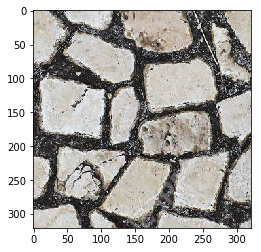

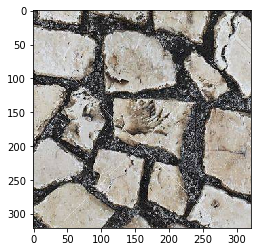

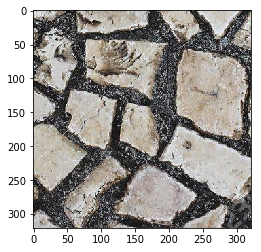

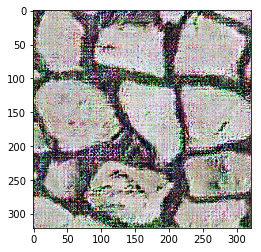

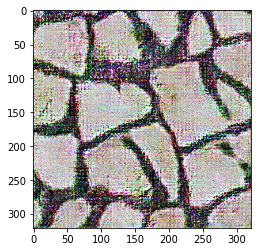

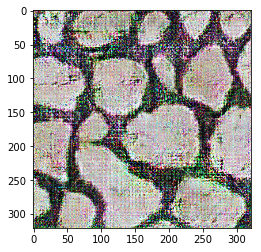

('saving PSGAN parameters in file: ', 'stone_road')
('Last Gcost=', 6.9580374, '  Last Dcost=', 0.0046286201)
('Gcost=', 7.1722078, '  Dcost=', 0.003871792)
('saving PSGAN parameters in file: ', 'stone_road')


In [7]:
##
# sample used just for visualisation
z_sample        = sample_noise_tensor(c,1,c.zx_sample,c.zx_sample_quilt)
epoch           = 0
tot_iter        = 0

while epoch < 36:
        epoch       += 1
        print("Epoch %d" % epoch)

        Gcost = []
        Dcost = []

        iters = c.epoch_iters / c.batch_size
        for it, samples in enumerate(tqdm(c.data_iter(), total=iters)):
            if it >= iters:
                break
            tot_iter+=1

            # random samples for training
            Znp = sample_noise_tensor(c,c.batch_size,c.zx) 

            if tot_iter % (c.k+1) == 0:
                cost = psgan2.train_g(Znp)
                Gcost.append(cost)
            else:
                cost = psgan2.train_d(samples,Znp)
                Dcost.append(cost)

        clear_output()
        showPSGANoutput(samples[:3])

        samples =  psgan2.generate(Znp[:3])
        showPSGANoutput(samples)
        
        psgan2.save('stone_road')
        
        print("Last Gcost=", last_Gcost, "  Last Dcost=", last_Dcost)
        last_Gcost = np.mean(Gcost)
        last_Dcost = np.mean(Dcost)
        print("Gcost=", np.mean(Gcost), "  Dcost=", np.mean(Dcost))

psgan2.save('stone_road')

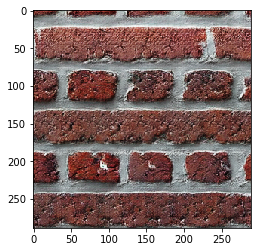

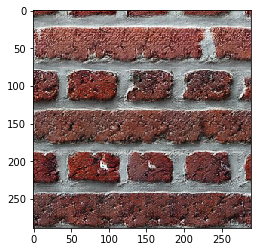

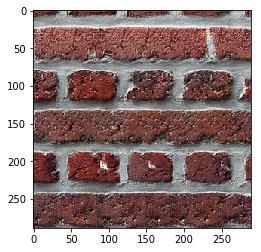

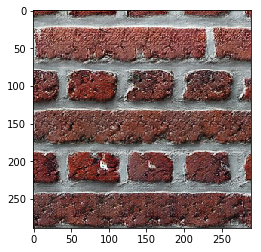

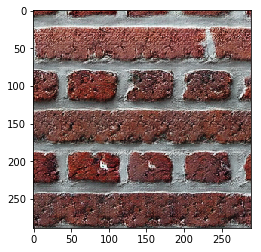

In [18]:
z_sample = sample_noise_tensor(psgan2.config,5,10,None)
img_tensors = psgan2.generate(z_sample)
showPSGANoutput(img_tensors)

In [16]:
np.sin(z_sample[2][1])

array([[-0.68463453, -0.52235806, -0.62541222,  0.18810615, -0.1629205 ,
        -0.52505261],
       [-0.75443734, -0.47441123, -0.82154988,  0.27299622, -0.73774643,
         0.61516696],
       [-0.02859255,  0.06572571, -0.61890734, -0.58316469,  0.27074695,
        -0.77096084],
       [-0.61283313,  0.00809068, -0.63751561, -0.04835356,  0.24923068,
        -0.48142307],
       [-0.55470945,  0.28948158, -0.15662956,  0.01341878, -0.72907301,
        -0.46875929],
       [-0.79718159,  0.41810972, -0.41266903,  0.68029579, -0.18896313,
         0.81982552]])

In [41]:
z_sample = sample_noise_tensor(psgan2.config,2,12,None)
np.sin(z_sample[1][-3])

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.00000000e-01,   5.00000000e-01,   5.00000000e-01,
          5.00000000e-01,   5.00000000e-01,   5.00000000e-01,
          5.00000000e-01,   5.00000000e-01,   5.00000000e-01,
          5.00000000e-01,   5.00000000e-01,   5.00000000e-01],
       [ -8.66025404e-01,  -8.66025404e-01,  -8.66025404e-01,
         -8.66025404e-01,  -8.66025404e-01,  -8.66025404e-01,
         -8.66025404e-01,  -8.66025404e-01,  -8.66025404e-01,
         -8.66025404e-01,  -8.66025404e-01,  -8.66025404e-01],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
    